In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

## **1. Import the data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

total_data = pd.read_csv('/content/drive/MyDrive/Assignment_1_data.csv')

Mounted at /content/drive


## **2. Data Preprocessing**
  2.1 Missing Values

In [4]:
#data preprocessing - missing data
for col in total_data.columns:  
    #remove the columns with more than 50% missing data
    if  total_data[col].isnull().sum()> 36489 * 0.5:
        del total_data[col]    
    #impute the rest with mean value
    elif total_data[col].isnull().sum() > 0:
        total_data[col].fillna(total_data[col].mean(),inplace=True)

2.2 Categorical Data

In [5]:
features_dummies = pd.get_dummies(total_data['gender'])
total_data = pd.concat([total_data,features_dummies], axis = 1)
del total_data['gender']

2.3 Split Target Variable and Other Variables

In [6]:
#split X and Y(varibles and target)
total_Y = total_data['outcome']
total_X = total_data.drop('outcome',axis = 1)

2.4 Normalization

In [7]:
#Z-Normalization
zscore_scaler=preprocessing.StandardScaler()
total_X_scaler = pd.DataFrame(zscore_scaler.fit_transform(total_X.values),columns = total_X.columns)

2.5 Correlation Analysis

<AxesSubplot:>

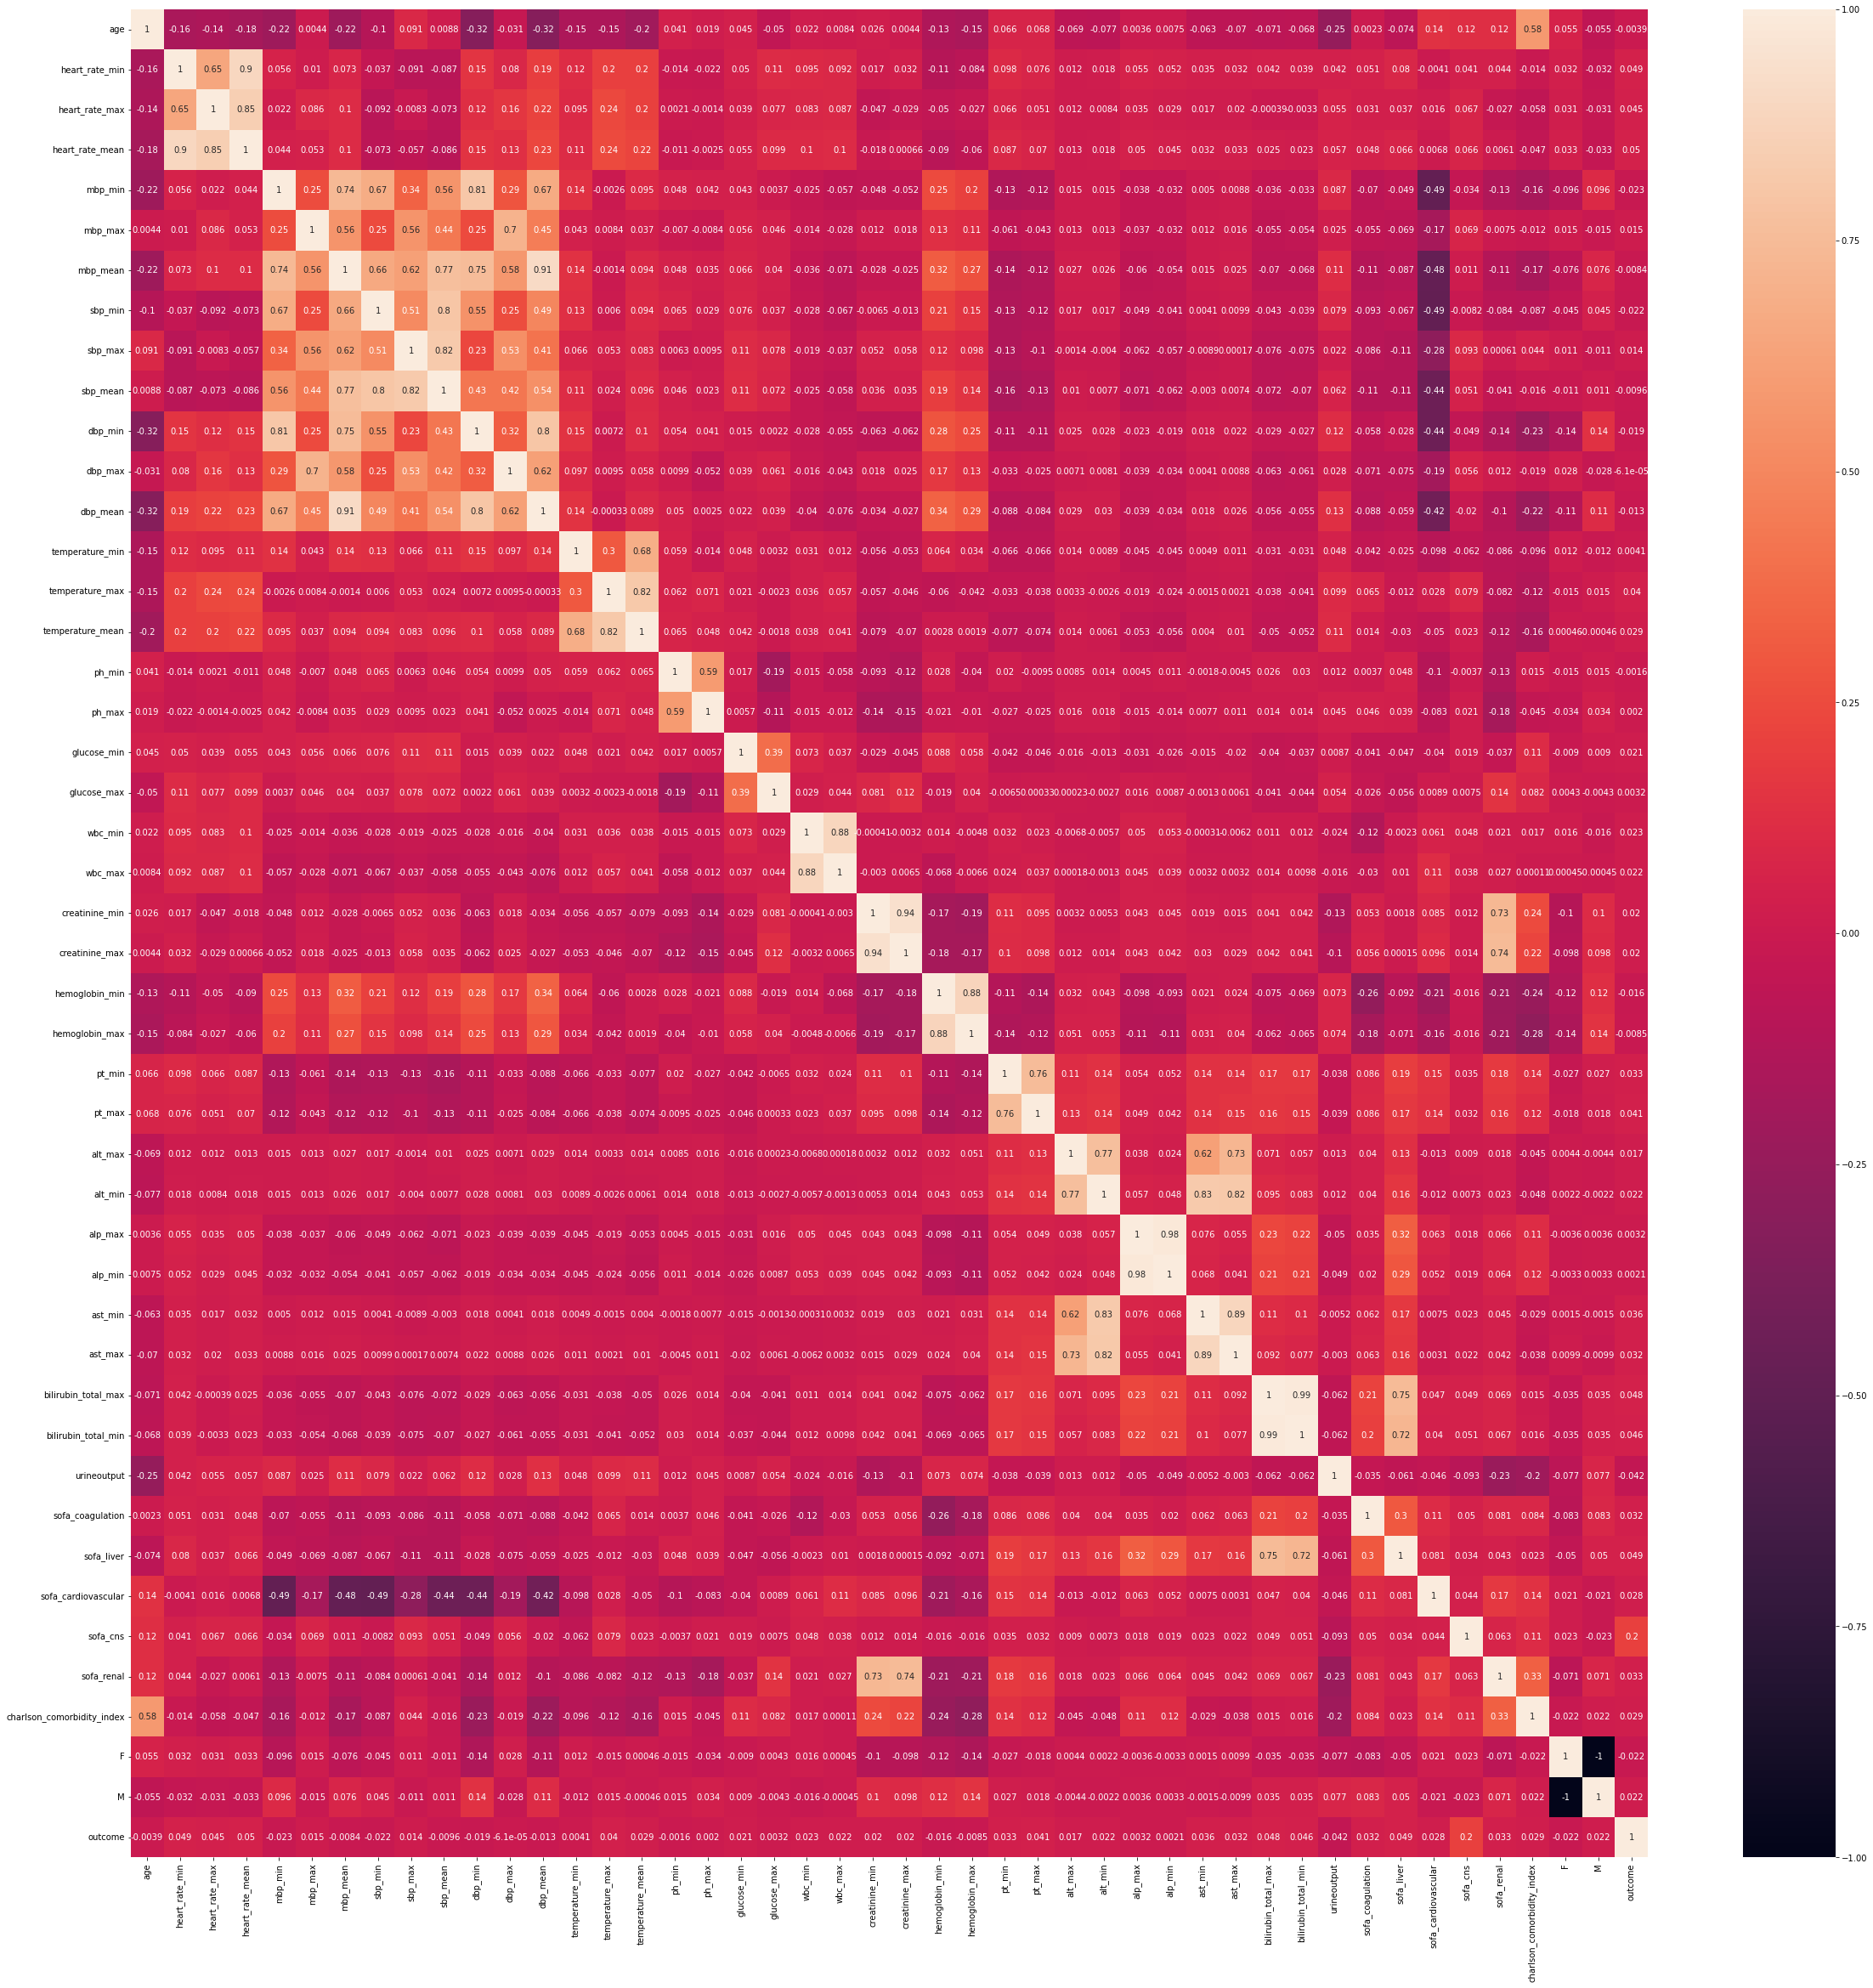

In [19]:
#correlation
total_data_scaler = pd.concat([total_X_scaler,total_Y], axis = 1)
total_data_corr = total_data_scaler.corr()
plt.figure(figsize = (40,40))
sns.heatmap(total_data_corr,vmin = -1,vmax = 1,annot = True)

2.6 Variance Inflation Factor

In [8]:
#vif
vif = pd.DataFrame()
vif["VIF_factor"] = [variance_inflation_factor(total_X_scaler.values, i)
                     for i in range(total_X_scaler.shape[1])]
vif["features"] = total_X_scaler.columns
print(vif)

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    VIF_factor                    features
0     1.942677                         age
1     7.010068              heart_rate_min
2     4.730302              heart_rate_max
3    14.326250             heart_rate_mean
4     4.299904                     mbp_min
5     2.913810                     mbp_max
6    27.586890                    mbp_mean
7     4.415202                     sbp_min
8     4.804414                     sbp_max
9    12.523087                    sbp_mean
10    5.430941                     dbp_min
11    3.537079                     dbp_max
12   19.497403                    dbp_mean
13    3.109778             temperature_min
14    5.140246             temperature_max
15    8.696122            temperature_mean
16    1.704075                      ph_min
17    1.659788                      ph_max
18    1.275143                 glucose_min
19    1.356013                 glucose_max
20    5.359688                     wbc_min
21    5.380010                     wbc_max
22   10.044

## **3. PCA and Other Preprocessing**
  3.1 Calculate the number of Principle Componets

In [8]:
#PCA
#calculate the number of Principle Components
def PCA_n_components(dt):
    pca = PCA(n_components = dt.shape[1])
    pca_X = pca.fit_transform(dt)
    vr = pca.explained_variance_ratio_
    cum_vr = np.cumsum(vr)
    n = np.argmax(cum_vr >= 0.95) + 1
    return n

3.2 PCA

In [9]:
#PCA
pca = PCA(n_components = PCA_n_components(total_X_scaler))
pca_X = pca.fit_transform(total_X_scaler)
col = ['pca' + str(i) for i in range(1,28)]
pca_df = pd.DataFrame(pca_X, columns = col)

3.3 Split training dataset and test dataset

In [10]:
#split dataset
train_X, test_X, train_Y, test_Y = train_test_split(pca_df, total_Y, test_size=0.2, random_state=0, shuffle = True)

3.4 Data Sampling

In [11]:
smo = SMOTE(sampling_strategy='auto',random_state=6)
smo_X, smo_Y = smo.fit_resample(train_X, train_Y)

## **4. Modeling**

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.svm import SVC

4.1 Logistic Regression

In [ ]:
'''Grid Search for Logistic Regression (5-fold cross validation)'''
param_grid = {'penalty': ['l2'], 
              'C': np.logspace(-2, 1, 4), 
              'solver': ['liblinear'], 
              'max_iter': [100,300,500]}

lr = LogisticRegression()
GS = GridSearchCV(lr, param_grid, cv = 5, scoring = 'f1')
GS.fit(smo_X,smo_Y)
print('Best Params:' + str(GS.best_params_))
print('Best Score:' + str(GS.best_score_))

In [48]:
lr = LogisticRegression(C = 0.5, max_iter = 150, penalty = 'l2',  solver = 'liblinear' , class_weight = 'balanced')
lr_model = lr.fit(smo_X,smo_Y)
pred_Y = lr_model.predict(test_X)

Logistic Regression
accuracy score: 0.753 
precision score: 0.949 
recall score: 0.753 
f1 Socre: 0.829 
AUC: 0.696
Confusion Matrix: 
[[5321 1708]
 [  98  171]]


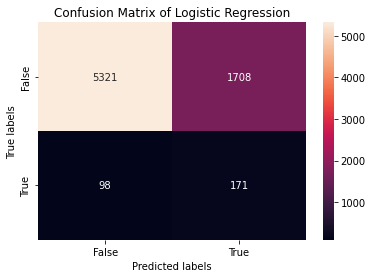

In [49]:
#evaluation
print('Logistic Regression')
print('accuracy score: %.3f ' %accuracy_score(test_Y, pred_Y))
print('precision score: %.3f ' %precision_score(test_Y, pred_Y,average = 'weighted'))
print('recall score: %.3f ' %recall_score(test_Y, pred_Y,average = 'weighted'))
print('f1 Socre: %.3f ' %f1_score(test_Y, pred_Y,average = 'weighted'))
print('AUC: %.3f' % roc_auc_score(test_Y, pred_Y))
cm = confusion_matrix(test_Y, pred_Y)
print('Confusion Matrix: ')
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Logistic Regression')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()


4.2 Decision Tree

In [ ]:
param_grid = {
  'max_depth':[3,7,10],
  'min_samples_leaf':[1,3,5],
  'min_samples_split':[2,5,10]
}

dtc = DecisionTreeClassifier(random_state=66)
GS1 = GridSearchCV(dtc,param_grid,cv = 5,scoring = 'f1')
GS1.fit(smo_X,smo_Y)
print('Best Params:' + str(GS1.best_params_))
print('Best Score:' + str(GS1.best_score_))

In [50]:
dtc = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 3, min_samples_split = 3,random_state = 66)
dtc_model = dtc.fit(smo_X,smo_Y)
pred_Y = dtc_model.predict(test_X)

Decision Tree
accuracy score: 0.747 
precision score: 0.943 
recall score: 0.747 
f1 Socre: 0.826 
AUC: 0.638
Confusion Matrix: 
[[5315 1714]
 [ 129  140]]


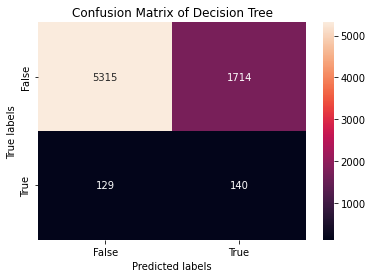

In [52]:
#evaluation
print('Decision Tree')
print('accuracy score: %.3f ' %accuracy_score(test_Y, pred_Y))
print('precision score: %.3f ' %precision_score(test_Y, pred_Y,average = 'weighted'))
print('recall score: %.3f ' %recall_score(test_Y, pred_Y,average = 'weighted'))
print('f1 Socre: %.3f ' %f1_score(test_Y, pred_Y,average = 'weighted'))
print('AUC: %.3f' % roc_auc_score(test_Y, pred_Y))
cm = confusion_matrix(test_Y, pred_Y)
print('Confusion Matrix: ')
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Decision Tree')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

4.3 Random Forest

In [ ]:
param_grid = {
  'n_estimators':[50,100],
  'max_depth':[10,20],
  'min_samples_leaf': [1,5],
  'min_samples_split':[2,5],
  'max_features':[5,20]
}

rfc = RandomForestClassifier(random_state=66)
GS = GridSearchCV(rfc,param_grid,cv = 5,scoring = 'f1')
GS.fit(smo_X,smo_Y)
print('Best Params:' + str(GS.best_params_))
print('Best Score:' + str(GS.best_score_))

In [63]:
#Random Forest
rfc = RandomForestClassifier(random_state=66, max_depth = 10, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 100)
rfc_model = rfc.fit(smo_X,smo_Y)
pred_Y = rfc_model.predict(test_X)

Random Forest
accuracy score: 0.833 
precision score: 0.943 
recall score: 0.833 
f1 Socre: 0.880 
AUC: 0.640
Confusion Matrix: 
[[5965 1064]
 [ 153  116]]


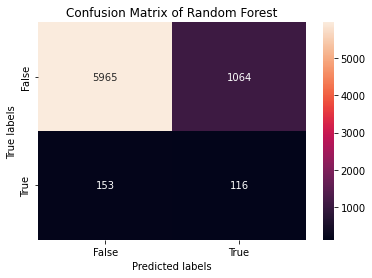

In [64]:
#evaluation
print('Random Forest')
print('accuracy score: %.3f ' %accuracy_score(test_Y, pred_Y))
print('precision score: %.3f ' %precision_score(test_Y, pred_Y,average = 'weighted'))
print('recall score: %.3f ' %recall_score(test_Y, pred_Y,average = 'weighted'))
print('f1 Socre: %.3f ' %f1_score(test_Y, pred_Y,average = 'weighted'))
print('AUC: %.3f' % roc_auc_score(test_Y, pred_Y))
cm = confusion_matrix(test_Y, pred_Y)
print('Confusion Matrix: ')
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Random Forest')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

4.4 AdaBoost

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
}
ada = AdaBoostClassifier()
GS = GridSearchCV(ada,param_grid,cv = 5,scoring = 'f1')
GS.fit(smo_X,smo_Y)
print('Best Params:' + str(GS.best_params_))
print('Best Score:' + str(GS.best_score_))

In [65]:
ada = AdaBoostClassifier(learning_rate = 0.05, n_estimators = 500)
ada_model = ada.fit(smo_X, smo_Y)
pred_Y = ada_model.predict(test_X)

AdaBoost
accuracy score: 0.741 
precision score: 0.948 
recall score: 0.741 
f1 Socre: 0.822 
AUC: 0.685
Confusion Matrix: 
[[5242 1787]
 [ 101  168]]


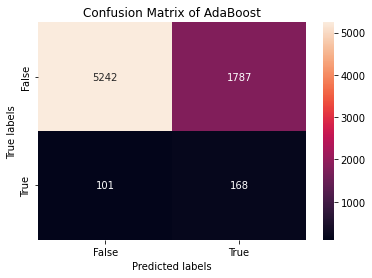

In [67]:
#evaluation
print('AdaBoost')
print('accuracy score: %.3f ' %accuracy_score(test_Y, pred_Y))
print('precision score: %.3f ' %precision_score(test_Y, pred_Y,average = 'weighted'))
print('recall score: %.3f ' %recall_score(test_Y, pred_Y,average = 'weighted'))
print('f1 Socre: %.3f ' %f1_score(test_Y, pred_Y,average = 'weighted'))
print('AUC: %.3f' % roc_auc_score(test_Y, pred_Y))
cm = confusion_matrix(test_Y, pred_Y)
print('Confusion Matrix: ')
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of AdaBoost')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

4.5 Gradient Boosting

In [ ]:
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 1],
    'max_depth': [3, 7],
    'min_samples_split': [2, 6],
    'min_samples_leaf': [1, 5],
}

gbc = GradientBoostingClassifier()
GS = GridSearchCV(gbc,param_grid,cv = 5,scoring = 'f1')
GS.fit(smo_X,smo_Y)
print('Best Params:' + str(GS.best_params_))
print('Best Score:' + str(GS.best_score_))

In [72]:
#GradientBoosting
gb = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 300, max_depth = 5, min_samples_split = 5, min_samples_leaf = 5)
gb_model = gb.fit(smo_X, smo_Y)
pred_Y = gb_model.predict(test_X)

Gradient Boosting
accuracy score: 0.855 
precision score: 0.940 
recall score: 0.855 
f1 Socre: 0.892 
AUC: 0.608
Confusion Matrix: 
[[6147  882]
 [ 177   92]]


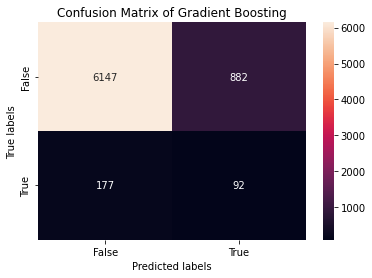

In [73]:
#evaluation
print('Gradient Boosting')
print('accuracy score: %.3f ' %accuracy_score(test_Y, pred_Y))
print('precision score: %.3f ' %precision_score(test_Y, pred_Y,average = 'weighted'))
print('recall score: %.3f ' %recall_score(test_Y, pred_Y,average = 'weighted'))
print('f1 Socre: %.3f ' %f1_score(test_Y, pred_Y,average = 'weighted'))
print('AUC: %.3f' % roc_auc_score(test_Y, pred_Y))
cm = confusion_matrix(test_Y, pred_Y)
print('Confusion Matrix: ')
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Gradient Boosting')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

4.6 SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.01, 0.1], 
              'kernel': ['rbf', 'sigmoid']}
svm = SVC()
GS =  GridSearchCV(svm, param_grid=param_grid, cv=5, n_jobs=-1)
GS.fit(smo_X,smo_Y)
print('Best Params:' + str(GS.best_params_))
print('Best Score:' + str(GS.best_score_))

In [14]:
#SVM
svm = SVC(C = 4, gamma = 0.01, kernel = 'rbf')
svm_model = svm.fit(smo_X,smo_Y)
pred_Y = svm_model.predict(test_X)

SVM
accuracy score: 0.801 
precision score: 0.940 
recall score: 0.801 
f1 Socre: 0.860 
AUC: 0.616
Confusion Matrix: 
[[5732 1297]
 [ 157  112]]


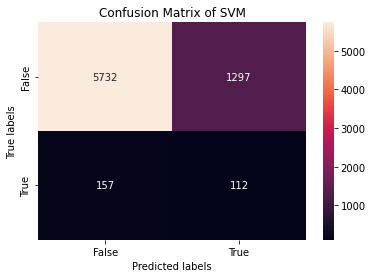

In [15]:
#evaluation
print('SVM')
print('accuracy score: %.3f ' %accuracy_score(test_Y, pred_Y))
print('precision score: %.3f ' %precision_score(test_Y, pred_Y,average = 'weighted'))
print('recall score: %.3f ' %recall_score(test_Y, pred_Y,average = 'weighted'))
print('f1 Socre: %.3f ' %f1_score(test_Y, pred_Y,average = 'weighted'))
print('AUC: %.3f' % roc_auc_score(test_Y, pred_Y))
cm = confusion_matrix(test_Y, pred_Y)
print('Confusion Matrix: ')
print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of SVM')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()